In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [4]:
split = int(0.9*len(x_train))
x_train1 = x_train[:split]
y_train1 = y_train[:split]
x_val = x_train[split:]
y_val = y_train[split:]

In [5]:
print(x_train1.shape)
print(y_train1.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(45000, 32, 32, 3)
(45000, 1)
(5000, 32, 32, 3)
(5000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [6]:
def identity_block(x,f,filters):
  F1,F2,F3 = filters
  x_skip = x
  x = layers.Conv2D(filters = F1,kernel_size = (1,1),strides = (1,1),padding = 'valid')(x)
  x = layers.BatchNormalization()(x,training = True)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters = F2,kernel_size = (f,f),strides = (1,1),padding = 'same')(x)
  x = layers.BatchNormalization()(x,training = True)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters = F3,kernel_size = (1,1),strides = (1,1),padding = 'valid')(x)
  x = layers.BatchNormalization()(x,training = True)

  x = layers.Add()([x,x_skip])
  x = layers.Activation('relu')(x)
  return x

In [7]:
def conv_block(x,f,filters,s = 2):
  F1,F2,F3 = filters
  x_skip = x
  x = layers.Conv2D(filters = F1,kernel_size = (1,1),strides = (s,s),padding = 'valid')(x)
  x = layers.BatchNormalization()(x,training = True)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters = F2,kernel_size = (f,f),strides = (1,1),padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters = F3,kernel_size = (1,1),strides = (1,1),padding = 'valid')(x)
  x = layers.BatchNormalization()(x)
  
  x_skip = layers.Conv2D(filters = F3,kernel_size = (1,1),strides = (s,s),padding = 'valid')(x_skip)
  x_skip = layers.BatchNormalization()(x_skip)

  x = layers.Add()([x,x_skip])
  x = layers.Activation('relu')(x)
  return x

In [8]:
inputs = keras.Input(shape = (32,32,3))
x = layers.ZeroPadding2D((3,3))(inputs)
x = layers.Conv2D(64,kernel_size = (7,7),strides = (2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = (3,3),strides = (2,2))(x)

x = conv_block(x,3,filters = [64,64,256],s = 1)
x = identity_block(x,3,[64,64,256])
x = identity_block(x,3,[64,64,256])

x = conv_block(x,3,[128,128,512],2)
x = identity_block(x,3,[128,128,512])
x = identity_block(x,3,[128,128,512])
x = identity_block(x,3,[128,128,512])

x = conv_block(x,3,[256,256,1024],2)
x = identity_block(x,3,[256,256,1024])
x = identity_block(x,3,[256,256,1024])
x = identity_block(x,3,[256,256,1024])
x = identity_block(x,3,[256,256,1024])
x = identity_block(x,3,[256,256,1024])

x = conv_block(x,3,[512,512,2048],2)
x = identity_block(x,3,[512,512,2048])
x = identity_block(x,3,[512,512,2048])

x = layers.AveragePooling2D(pool_size = (1,1))(x)

x = layers.Flatten()(x)
output = layers.Dense(10,activation = 'softmax')(x)

model = keras.Model(inputs = inputs,outputs = output)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [10]:
model.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.1,momentum = 0.9,),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics = ['accuracy'])

In [11]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',factor = 0.1,patience = 5,mode = 'max',cooldown = 0)

In [12]:
history = model.fit(x_train1,y_train1,batch_size = 256,epochs = 100,callbacks = [lr_reducer],validation_data = (x_val,y_val))

Epoch 1/100
176/176 [==============================] - 31s 114ms/step - loss: 6.2405 - accuracy: 0.1293 - val_loss: 6.0876 - val_accuracy: 0.1082 - lr: 0.1000
Epoch 2/100
176/176 [==============================] - 16s 90ms/step - loss: 2.7744 - accuracy: 0.2338 - val_loss: 2.8599 - val_accuracy: 0.2336 - lr: 0.1000
Epoch 3/100
176/176 [==============================] - 16s 90ms/step - loss: 2.1395 - accuracy: 0.3023 - val_loss: 1.9462 - val_accuracy: 0.3110 - lr: 0.1000
Epoch 4/100
176/176 [==============================] - 16s 89ms/step - loss: 1.8551 - accuracy: 0.3454 - val_loss: 1.8275 - val_accuracy: 0.3484 - lr: 0.1000
Epoch 5/100
176/176 [==============================] - 16s 89ms/step - loss: 1.7194 - accuracy: 0.3842 - val_loss: 1.7259 - val_accuracy: 0.3738 - lr: 0.1000
Epoch 6/100
176/176 [==============================] - 16s 89ms/step - loss: 1.6216 - accuracy: 0.4131 - val_loss: 1.6141 - val_accuracy: 0.4100 - lr: 0.1000
Epoch 7/100
176/176 [==============================

In [13]:
history1 = model.evaluate(x_test,y_test,batch_size = 256)

40/40 [==============================] - 2s 39ms/step - loss: 2.6275 - accuracy: 0.5866


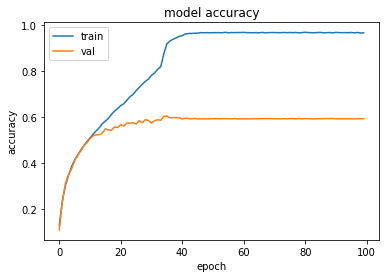

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

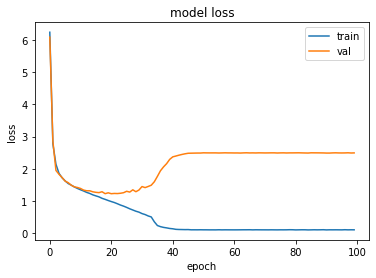

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')